In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD

from matplotlib import font_manager

preferred_fonts = [
    "AppleGothic",
    "NanumGothic",
    "Malgun Gothic",
    "Noto Sans CJK KR",
]
available_fonts = {f.name for f in font_manager.fontManager.ttflist}
for font in preferred_fonts:
    if font in available_fonts:
        plt.rcParams["font.family"] = font
        break
else:
    print("[경고] 한글 폰트를 찾지 못했습니다. 시스템 폰트를 확인해 주세요.")

plt.rcParams["axes.unicode_minus"] = False


In [29]:
# 1) 전체 데이터 로드
df = pd.read_csv("sms_all.csv")  # id, text, label 가정

print("전체 데이터 크기:", df.shape)
print(df["label"].value_counts())

# text, label만 사용
df = df[["text", "label"]]

X = df["text"].astype(str)
y = df["label"].astype(int)

전체 데이터 크기: (792108, 3)
label
0    403416
1    388692
Name: count, dtype: int64


In [30]:
# 2) train / test 분리 (층화)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Train 개수:", len(X_train), " / Test 개수:", len(X_test))

Train 개수: 633686  / Test 개수: 158422


In [31]:
# 3) TF-IDF 벡터
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(3, 5),
    min_df=3,
    max_features=100_000,  # 필요하면 나중에 150k, 200k 시험
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)

TF-IDF shape (train): (633686, 100000)
TF-IDF shape (test): (158422, 100000)


In [32]:
# 4) 나이브 베이즈 분류기
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

print("=== Naive Bayes (전체 데이터) 결과 ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion matrix (NB):")
print(cm_nb)


=== Naive Bayes (전체 데이터) 결과 ===
Accuracy: 0.9988764186792238
              precision    recall  f1-score   support

           0     0.9995    0.9983    0.9989     80683
           1     0.9982    0.9995    0.9989     77739

    accuracy                         0.9989    158422
   macro avg     0.9989    0.9989    0.9989    158422
weighted avg     0.9989    0.9989    0.9989    158422

Confusion matrix (NB):
[[80545   138]
 [   40 77699]]


In [33]:
# -------------------------
# SVM 학습 데이터 수 설정
# -------------------------
SVM_TRAIN_MAX = None   # ← 전체 train(60만+) 다 쓰고 싶으면 None
# SVM_TRAIN_MAX = 300_000  # ← 너무 버거우면 이렇게 숫자로 제한

X_train_svm = X_train_tfidf
y_train_svm = y_train.to_numpy()

if SVM_TRAIN_MAX is not None and X_train_svm.shape[0] > SVM_TRAIN_MAX:
    idx = np.random.choice(X_train_svm.shape[0], size=SVM_TRAIN_MAX, replace=False)
    X_train_svm = X_train_svm[idx]
    y_train_svm = y_train_svm[idx]
    print(f"SVM 학습용으로 {SVM_TRAIN_MAX}개만 사용")
else:
    print(f"SVM 학습용으로 train 전체 사용: {X_train_svm.shape[0]}개")

svm = LinearSVC(
    C=1.0,
    max_iter=2000,
)

svm.fit(X_train_svm, y_train_svm)

y_pred_svm = svm.predict(X_test_tfidf)

print("=== Linear SVM 결과 ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=4))

cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion matrix (SVM):")
print(cm_svm)


SVM 학습용으로 train 전체 사용: 633686개
=== Linear SVM 결과 ===
Accuracy: 0.9999431897085
              precision    recall  f1-score   support

           0     0.9999    1.0000    0.9999     80683
           1     1.0000    0.9999    0.9999     77739

    accuracy                         0.9999    158422
   macro avg     0.9999    0.9999    0.9999    158422
weighted avg     0.9999    0.9999    0.9999    158422

Confusion matrix (SVM):
[[80682     1]
 [    8 77731]]


In [34]:
import numpy as np

y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred_svm)
X_test_arr = np.array(X_test)

mis_idx = np.where(y_test_arr != y_pred_arr)[0]
print("오분류 개수:", len(mis_idx))

for i in mis_idx[:20]:
    print("=== 오분류 샘플 ===")
    print("실제 라벨:", y_test_arr[i], " / 예측:", y_pred_arr[i])
    print("문장:", X_test_arr[i])
    print()

false_neg = []  # 스팸인데 정상으로 예측됨
false_pos = []  # 정상인데 스팸으로 예측됨

for i in mis_idx:
    if y_test_arr[i] == 1 and y_pred_arr[i] == 0:
        false_neg.append(X_test_arr[i])
    elif y_test_arr[i] == 0 and y_pred_arr[i] == 1:
        false_pos.append(X_test_arr[i])

print("스팸→정상(false negative) :", len(false_neg))
print("정상→스팸(false positive) :", len(false_pos))

print("=== 스팸인데 정상으로 오분류된 것들 ===")
for t in false_neg[:20]:
    print("-", t)
    
print("=== 정상인데 스팸으로 오분류된 것들 ===")
for t in false_pos[:20]:
    print("-", t)


오분류 개수: 9
=== 오분류 샘플 ===
실제 라벨: 1  / 예측: 0
문장: 한진택배입니다 예슬님 프리미엄 골드 런치 연어&참치 **g 모아보기. 동구 경안로 *** [각산동, 대구혁신 LH*단지] ***동 ***호로 문앞배송하였습니다.

=== 오분류 샘플 ===
실제 라벨: 1  / 예측: 0
문장: 부자가 되는 비밀을 알아내고 운명을 바꿔보세요! 하루에 천만원씩 버는 비법 공개? 배우고싶으시다면 연락주세요 라인:tj**s

=== 오분류 샘플 ===
실제 라벨: 1  / 예측: 0
문장: 古い写真を見て、私はまたあなたのことを思い出しました。私は韓国に行くつもりです。会ってもいいですか。+ĻịṆẸ： zilin**

=== 오분류 샘플 ===
실제 라벨: 1  / 예측: 0
문장: Unknown님저번에 말씀드린지씨지놈 상장 확정입니다매주+? 무료 스펙주드려요*h*.io/ldl

=== 오분류 샘플 ===
실제 라벨: 1  / 예측: 0
문장: 성욕 강한 오빠를 만나고 싶어용~  L̆̈ï͎N͎̽E kgg** 으로 연락줘요 잘 맞으면 장기적으로 연락하고 싶어요~

=== 오분류 샘플 ===
실제 라벨: 1  / 예측: 0
문장: 무▼로▼료▼또▼한달안에 최소* 등 보 장돈내지마세요제가 그  꿈을 이루어드릴게요!!!http://dll.kr/kAu

=== 오분류 샘플 ===
실제 라벨: 1  / 예측: 0
문장: ****년에도 늘 건강하시고 행운과 행복이 가득하시길 바랍니다! Evolution, Pragmatic Play 등 라이브

=== 오분류 샘플 ===
실제 라벨: 1  / 예측: 0
문장: 오랫동안 인연을 맺을 수 있는 성실한 파트너를 찾고 있습니다 만, 싱글이시라면 저를 추가해 주세요 Ḻ INé E： gnsst

=== 오분류 샘플 ===
실제 라벨: 0  / 예측: 1
문장: ***** **** ** 진짜 예뻤죠

스팸→정상(false negative) : 8
정상→스팸(false positive) : 1
=== 스팸인데 정상으로 오

In [35]:
# 5) 모델별 주요 지표 요약표 생성
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

summary_rows = [
    {"model": "Multinomial NB", "metric": "Accuracy", "value": accuracy_score(y_test, y_pred_nb)},
    {"model": "Linear SVM", "metric": "Accuracy", "value": accuracy_score(y_test, y_pred_svm)},
    {"model": "Multinomial NB", "metric": "Macro Precision", "value": report_nb["macro avg"]["precision"]},
    {"model": "Linear SVM", "metric": "Macro Precision", "value": report_svm["macro avg"]["precision"]},
    {"model": "Multinomial NB", "metric": "Macro Recall", "value": report_nb["macro avg"]["recall"]},
    {"model": "Linear SVM", "metric": "Macro Recall", "value": report_svm["macro avg"]["recall"]},
    {"model": "Multinomial NB", "metric": "Macro F1", "value": report_nb["macro avg"]["f1-score"]},
    {"model": "Linear SVM", "metric": "Macro F1", "value": report_svm["macro avg"]["f1-score"]},
]

summary_df = pd.DataFrame(summary_rows)
summary_table = summary_df.pivot(index="metric", columns="model", values="value").sort_index()
summary_table.round(6)


model,Linear SVM,Multinomial NB
metric,,
Accuracy,0.999943,0.998876
Macro F1,0.999943,0.998876
Macro Precision,0.999944,0.998865
Macro Recall,0.999942,0.998888


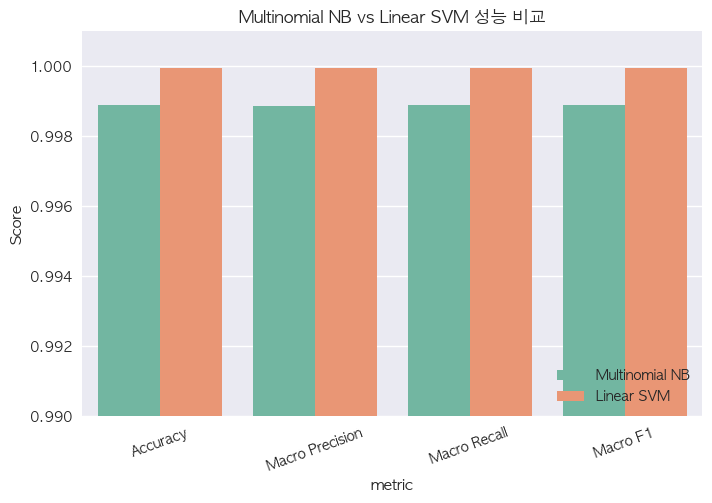

In [40]:
# 6) 요약 지표 막대 그래프
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(8, 5))
plt.rcParams["font.family"] = "AppleGothic"  # 실제 존재하는 이름으로 변경
sns.barplot(data=summary_df, x="metric", y="value", hue="model", palette="Set2")
plt.ylim(0.99, 1.001)
plt.ylabel("Score")
plt.title("Multinomial NB vs Linear SVM 성능 비교")
plt.xticks(rotation=20)
plt.legend(loc="lower right")
plt.show()


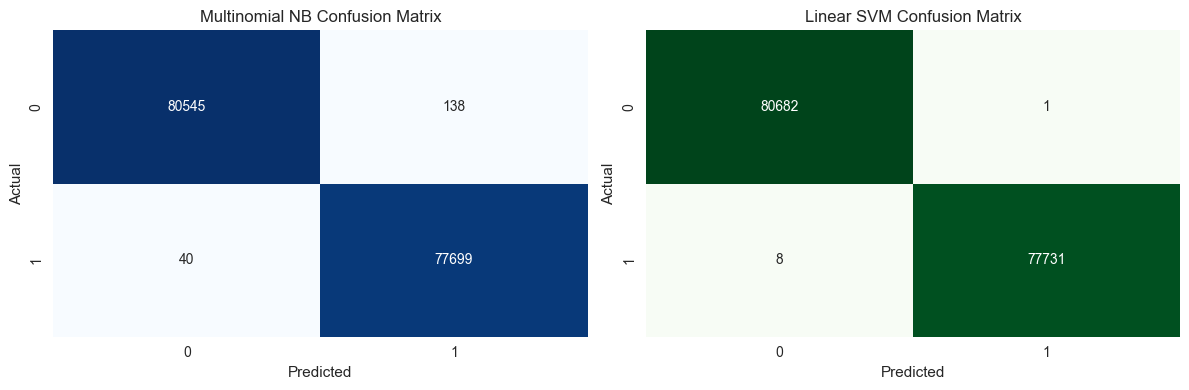

In [37]:
# 7) 혼동 행렬 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Multinomial NB Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Linear SVM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


/Users/mingyu/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mingyu/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mingyu/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mingyu/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mingyu/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing fr

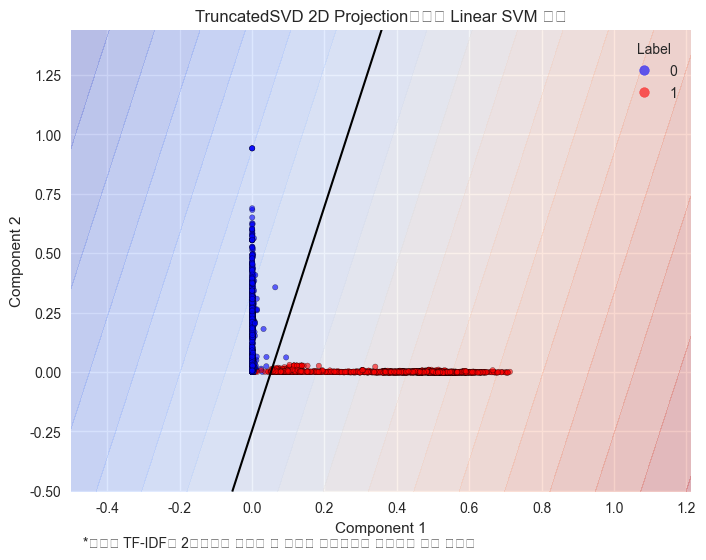

In [ ]:
# 8) 2차원 투영 기반 Linear SVM 경계 시각화 (샘플 기반)
PLOT_SAMPLE = 4000
random_state = np.random.RandomState(42)

sample_size = min(PLOT_SAMPLE, X_test_tfidf.shape[0])
idx = random_state.choice(X_test_tfidf.shape[0], size=sample_size, replace=False)
X_plot_sparse = X_test_tfidf[idx]
y_plot = y_test.to_numpy()[idx]
plt.rcParams["font.family"] = "AppleGothic"  # 실제 존재하는 이름으로 변경

svd = TruncatedSVD(n_components=2, random_state=42)
X_plot_2d = svd.fit_transform(X_plot_sparse)

svm_2d = LinearSVC(C=1.0, max_iter=5000, random_state=42)
svm_2d.fit(X_plot_2d, y_plot)

x_min, x_max = X_plot_2d[:, 0].min() - 0.5, X_plot_2d[:, 0].max() + 0.5
y_min, y_max = X_plot_2d[:, 1].min() - 0.5, X_plot_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300),
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = svm_2d.decision_function(grid).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=20, cmap="coolwarm", alpha=0.3)
plt.contour(xx, yy, Z, levels=[0], colors="k", linewidths=1.5)
scatter = plt.scatter(
    X_plot_2d[:, 0],
    X_plot_2d[:, 1],
    c=y_plot,
    cmap="bwr",
    edgecolor="k",
    alpha=0.6,
    s=15,
)
plt.title("TruncatedSVD 2D Projection에서의 Linear SVM 경계")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(*scatter.legend_elements(), title="Label", loc="upper right")
plt.text(
    0.02,
    -0.12,
    "*고차원 TF-IDF를 2차원으로 투영한 후 경계를 근사적으로 확인하기 위한 시각화",
    transform=plt.gca().transAxes,
)
plt.show()
